In [ ]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz

import json
from glob import glob

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
NFFT = 1024
SAMPLE_RATE = 2_048_000

In [4]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return (spectrum, frequencies), params

In [5]:
datasets = []
for run in glob('../data/*calibration*.dat'):
    print(run)
    datasets.append(load(run))

In [6]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [16]:
def plot_ra_dec(datasets: list, reference_position: tuple[float, float]):
    ra = [param.get('ra_dec')[0] for (_, _), param in datasets]
    dec = [param.get('ra_dec')[1] for (_, _), param in datasets]

    ra_rel = [r - reference_position[0] for r in ra]
    dec_rel = [d - reference_position[1] for d in dec]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    plt.scatter(ra, dec, c=averages)
    plt.scatter(*reference_position, marker='o', s=50)
    plt.xlabel(r"Ra [$^\circ$]")
    plt.ylabel(r"Dec [$^\circ$]")

In [24]:
def plot_az_alt(datasets: list, reference_position: tuple[float, float]):
    az = [param.get('az_alt')[0] for (_, _), param in datasets]
    alt = [param.get('az_alt')[1] for (_, _), param in datasets]

    az_rel = [r - reference_position[0] for r in az]
    alt_rel = [d - reference_position[1] for d in alt]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    plt.scatter(az, alt, c=averages)
    plt.scatter(*reference_position, marker='o', s=50)
    plt.xlabel(r"Ra [$^\circ$]")
    plt.ylabel(r"Dec [$^\circ$]")

In [25]:
def estimate_correction_az_alt(datasets: list, reference_position: tuple[float, float]) -> tuple[float, float]:
    az_alt = [param.get('az_alt') for (_, _), param in datasets]

    az_alt_rel = [(r[0] - reference_position[0], r[1] - reference_position[1]) for r in az_alt]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    idx_max = np.argmax(averages)
    correction = az_alt_rel[idx_max]

    return correction

In [ ]:
def get_corrected_target_ra_dec(target_position_ra_dec, correction_az_alt):
    observing_location = EarthLocation(lat='46.519611', lon='6.565056', height=400*u.m)  
    observing_time = Time('2017-02-05 20:12:18')  
    aa = AltAz(location=observing_location, obstime=observing_time)

    coord = SkyCoord('4h42m', '-38d6m50.8s')
    coord.transform_to(aa)

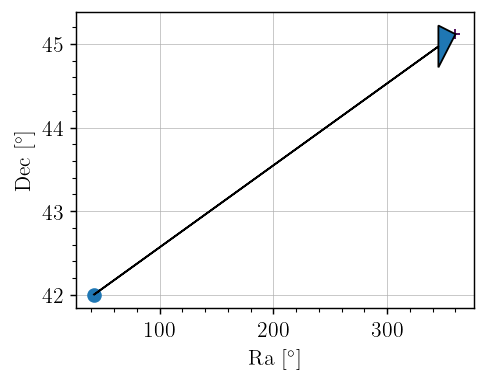

In [ ]:
# Testing
stuff = [load('../data/test1_2025_02_21_10_20_51_raw.dat')]
x, y = estimate_correction_az_alt(stuff, (42, 42))
plot_az_alt(stuff, (42, 42))
plt.arrow(42, 42, x, y, length_includes_head=True, head_width=0.5, head_length=15)